# City45 weather data - 1Layer

In [1]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # using specific GPU
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.logging.set_verbosity(tf.logging.ERROR)

from compatible.likelihoods import MultiClass, Gaussian
from compatible.kernels import RBF, White
from gpflow.models.svgp import SVGP
from gpflow.training import AdamOptimizer, ScipyOptimizer
from scipy.stats import mode
from scipy.cluster.vq import kmeans2
import gpflow
from gpflow.mean_functions import Identity, Linear
from gpflow.mean_functions import Zero
from gpflow import autoflow, params_as_tensors, ParamList
import pandas as pd
import itertools
pd.options.display.max_rows = 999
import gpflow_monitor

from scipy.cluster.vq import kmeans2
from scipy.stats import norm
from scipy.special import logsumexp
from scipy.io import loadmat
from gpflow_monitor import *
print('tf_ver:', tf.__version__, 'gpflow_ver:', gpflow.__version__)
from tensorflow.python.client import device_lib
print('avail devices:\n'+'\n'.join([x.name for x in device_lib.list_local_devices()]))
from jack_utils.common import time_it
import sys
import gpflow.training.monitor as mon

# our impl
from dgp_graph import *

tf_ver: 1.15.0 gpflow_ver: 1.5.0
avail devices:
/device:CPU:0
/device:XLA_CPU:0
/device:XLA_GPU:0


Using TensorFlow backend.


In [2]:
plt.rcParams['figure.dpi'] = 100
np.random.seed(123456)

# Load data

In [3]:
path = './data'

# Load Adjacency
gmat0 = loadmat(os.path.join(path, 'city45_gmat.mat'))['gmat']
print('raw adj shape:', gmat0.shape)

raw adj shape: (45, 45)


In [4]:
def normalize_data(data, mu, std):
    res = (data-mu) / std
    return res

def unnormalize_data(data, mu, std):
    res = data * std + mu
    return res

In [5]:
trX0 = loadmat(os.path.join(path, 'city45_trX.mat'))['X_train']
trY0 = loadmat(os.path.join(path, 'city45_trY.mat'))['Y_train']

teX0 = loadmat(os.path.join(path, 'city45_teX.mat'))['X_test']
teY0 = loadmat(os.path.join(path, 'city45_teY.mat'))['Y_test']

In [6]:
trY0, teY0 = trY0[:, :, None], teY0[:, :, None]

In [7]:
mu_trX0, std_trX0 = np.mean(trX0, axis=0), np.std(trX0, axis=0)
mu_trY0, std_trY0 = np.mean(trY0, axis=0), np.std(trY0, axis=0)
# mu_teX0, std_teX0 = np.mean(teX0, axis=0), np.std(teX0, axis=0)
# mu_teY0, std_teY0 = np.mean(teY0, axis=0), np.std(teY0, axis=0)

In [8]:
trX = normalize_data(trX0, mu_trX0, std_trX0)
trY = normalize_data(trY0, mu_trY0, std_trY0)
teX = normalize_data(teX0, mu_trX0, std_trX0)
teY = normalize_data(teY0, mu_trY0, std_trY0)

In [9]:
def get_sparsity(adj):
    avg_deg = np.mean([np.count_nonzero(x) for x in adj])
    return 100*(1 - (np.count_nonzero(adj) / (adj.shape[0]**2))), avg_deg

# def thresh(adj0, t=0.1):
#     adj = np.copy(adj0)
#     adj[adj0>t] = 0
#     adj[adj0<=t] = 1
#     return adj

def thresh(adj0, dg=3):
    adj = np.zeros(adj0.shape)
    for i in range(adj.shape[0]):
        adj[i, np.argsort(adj0[i, :])[:dg]] = 1
    return adj

In [10]:
gmat = thresh(gmat0, dg=5)
get_sparsity(gmat)

(88.88888888888889, 5.0)

gmat = np.eye(gmat.shape[0])

# Data visualization

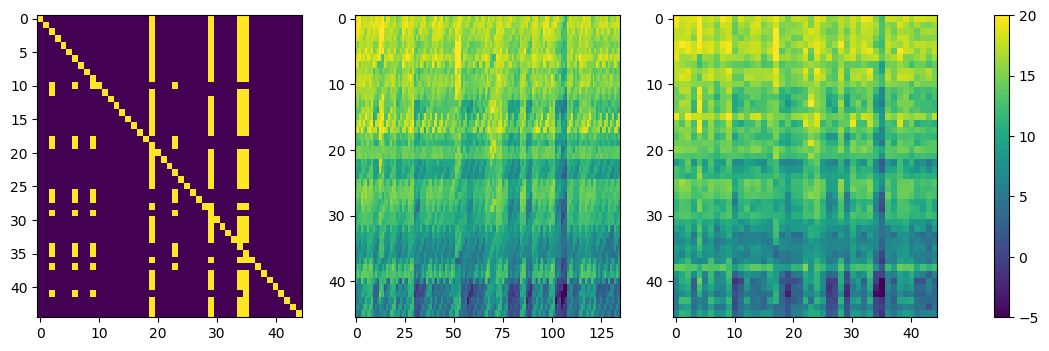

In [28]:
import matplotlib.gridspec as gridspec

fig, axes = plt.subplots(1,3)
# for ax in axes.flat:
axes[0].imshow(gmat, vmin=0, vmax=1, aspect='auto')
axes[1].imshow(trX0.reshape(trX0.shape[0],-1), vmin=-5, vmax=20, aspect='auto')
im = axes[2].imshow(trY0.reshape(trY0.shape[0],-1), vmin=-5, vmax=20, aspect='auto')


plt.subplots_adjust(right=2)
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

In [14]:
def imshow2d(x):
    plt.imshow(x.reshape(x.shape[0], -1))
    plt.colorbar()

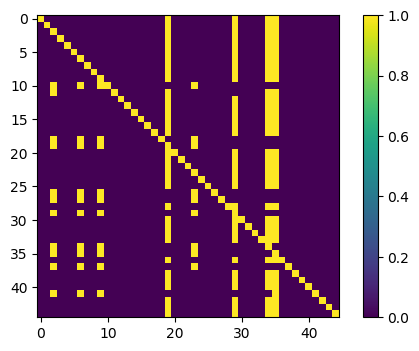

In [15]:
plt.imshow(gmat)
plt.colorbar()

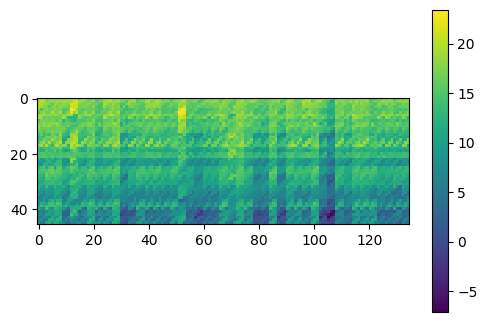

In [16]:
imshow2d(trX0)

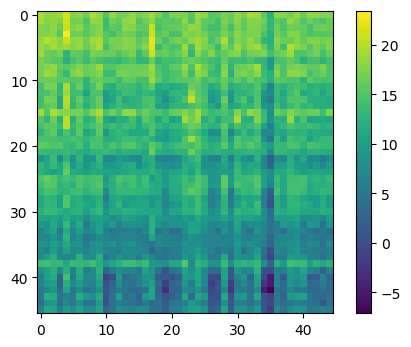

In [17]:
imshow2d(trY0)

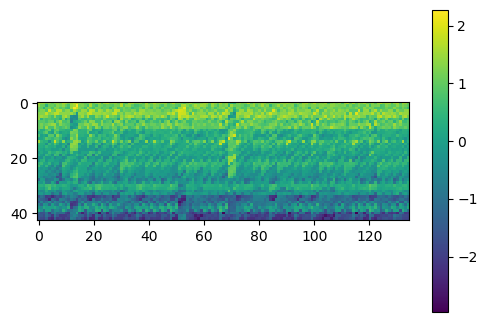

In [15]:
imshow2d(teX)

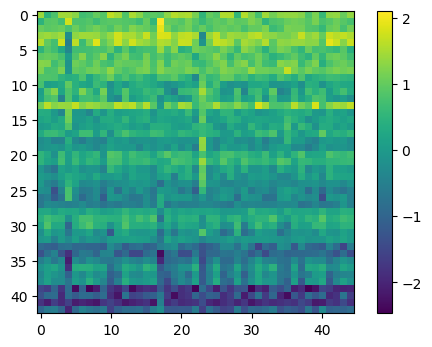

In [16]:
imshow2d(teY)

# Training

In [17]:
nodes = gmat.shape[0]
M = 5

Z = np.stack([kmeans2(trX[:,i], M, minit='points')[0] for i in range(nodes)],axis=1)  # (M=s2=10, n, d_in=5)
print('inducing points Z: {}'.format(Z.shape))

inducing points Z: (5, 45, 3)


In [18]:
adj = gmat.astype('float64')
input_adj = adj # adj  / np.identity(adj.shape[0]) /  np.ones_like(adj)

In [19]:
with gpflow.defer_build():
    m_dgpg = DGPG(trX, trY, Z, [3], Gaussian(), input_adj,
                  agg_op_name='concat3d', ARD=True,
                  is_Z_forward=True, mean_trainable=False, out_mf0=True,
                  num_samples=20, minibatch_size=80,
                  kern_type='RBF'
                  #kern_type='Matern32'
                 )
    # m_sgp = SVGP(X, Y, kernels, Gaussian(), Z=Z, minibatch_size=minibatch_size, whiten=False)
m_dgpg.compile()
model = m_dgpg

input-output dim (3(agg:135)->1)
func __init__ consumed 0.3s


In [20]:
session = m_dgpg.enquire_session()
optimiser = gpflow.train.AdamOptimizer(0.01)
global_step = mon.create_global_step(session)

In [21]:
maxiter=2000

exp_path="./exp/city45-M5-thdg5-3-1-1-2k-rbf"
#exp_path="./exp/temp"

print_task = mon.PrintTimingsTask()\
    .with_name('print')\
    .with_condition(mon.PeriodicIterationCondition(10))\

checkpoint_task = mon.CheckpointTask(checkpoint_dir=exp_path)\
        .with_name('checkpoint')\
        .with_condition(mon.PeriodicIterationCondition(15))\

with mon.LogdirWriter(exp_path) as writer:
    tensorboard_task = mon.ModelToTensorBoardTask(writer, model)\
        .with_name('tensorboard')\
        .with_condition(mon.PeriodicIterationCondition(100))\
        .with_exit_condition(True)
    monitor_tasks = [tensorboard_task, checkpoint_task] # [print_task, tensorboard_task]
    
       
    with mon.Monitor(monitor_tasks, session, global_step, print_summary=True) as monitor:
        optimiser.minimize(model, step_callback=monitor, global_step=global_step, maxiter=maxiter)

Tasks execution time summary:
tensorboard:	2.2797 (sec)
checkpoint:	20.9293 (sec)


# Results

In [22]:
from jack_utils.my_metrics import *
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
def assess_model_rmse(model, X_batch, Y_batch, S = 10):
    m, v = model.predict_y(X_batch, S)
    pred = np.mean(m, axis=0)
    var = np.mean(v, axis=0)
    loss = np.sum((Y_batch.flatten()-pred.flatten())**2)
    return loss, pred, var

def batch_assess_rmse(model, X, Y, batch_size=1, S=10):
    n_batches = max(int(len(X)/batch_size), 1)
    rms = len(X) - n_batches*batch_size
    losses, preds, varis = [], [], []
    Xr, Yr = X[-rms:, :], Y[-rms:, :]
    for X_batch, Y_batch in zip(np.split(X[:n_batches*batch_size], n_batches), np.split(Y[:n_batches*batch_size], n_batches)):
        l, pred, vari = assess_model_rmse(model, X_batch, Y_batch, S=S)
        losses.append(l)
        preds.append(pred)
        varis.append(vari)
    if rms > 0:
        l, pred, vari = assess_model_rmse(model, Xr, Yr, S=S)
        losses.append(l)        
        preds.append(pred)
        varis.append(vari)
    ndata = Y.shape[0] * Y.shape[1]
    avg_loss = np.sqrt(np.sum(losses) / ndata)
    y_pred = np.concatenate(preds)
    y_var = np.concatenate(varis)
    return avg_loss, y_pred, y_var

In [24]:
# make predictions of our model
sample_X0, sample_Y0 = teX0, teY0.squeeze()
sample_X, sample_Y = teX, teY.squeeze()

In [25]:
%%time
pred_rmse, predY, varY = batch_assess_rmse(model, sample_X.reshape(sample_X.shape[0], -1), sample_Y.reshape(sample_Y.shape[0], -1))
print(pred_rmse)

0.4489299881707769
CPU times: user 1.53 s, sys: 160 ms, total: 1.69 s
Wall time: 980 ms


In [26]:
predY0 = unnormalize_data(predY[:,:,None], mu_trY0, std_trY0).squeeze()

metrics:	[mae | rmse | mape]
ours DGP:	 [1.382, 1.808, 0.155]
yesterday:	 [1.374, 1.826, 0.162]
day-mean:	 [1.609, 2.105, 0.171]
day_median:	 [1.674, 2.232, 0.18]


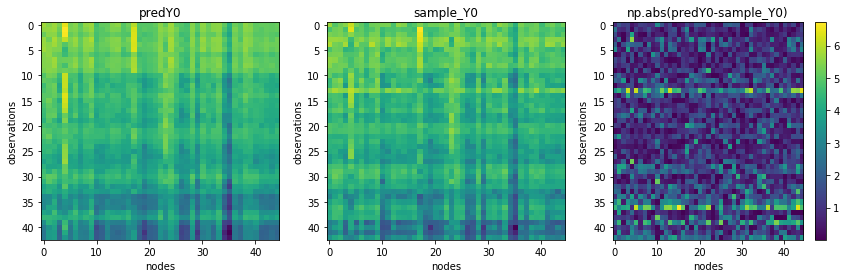

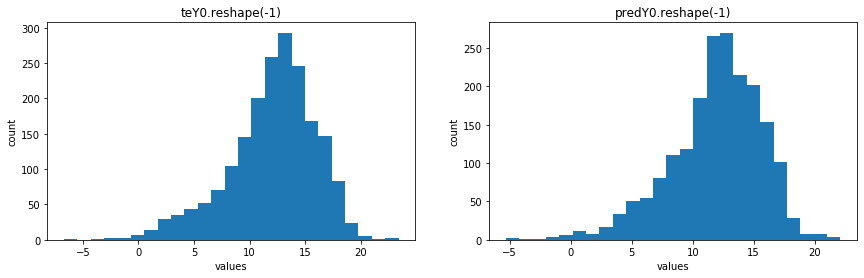

In [27]:
# show rmse of all baselines
metrics = [np_mae, np_rmse, np_mape]
e_dgp = [np.round(f(predY0, sample_Y0.squeeze()), 3) for f in metrics]
e_last = [np.round(f(sample_X0[:,:,-1], sample_Y0.squeeze()), 3) for f in metrics]
e_ha = [np.round(f(sample_X0.mean(axis=-1), sample_Y0.squeeze()), 3) for f in metrics]
e_mid = [np.round(f(np.median(sample_X0, axis=-1), sample_Y0.squeeze()), 3) for f in metrics]
print('metrics:\t[mae | rmse | mape]')
print('ours DGP:\t', e_dgp)
print('yesterday:\t', e_last)
print('day-mean:\t', e_ha)
print('day_median:\t', e_mid)

# visualization of prediction(mean)
fig, axs = plt.subplots(1, 3)
max_val = sample_Y0.max()*1.1
for i, to_show in enumerate('predY0,sample_Y0,np.abs(predY0-sample_Y0)'.split(',')):
    im = axs[i].imshow(eval(to_show))
    axs[i].set_title(to_show); axs[i].set_aspect('auto');
    axs[i].set_xlabel('nodes'); axs[i].set_ylabel('observations');
fig.colorbar(im, ax=axs[-1])
plt.subplots_adjust(right=2)
plt.show()

# visualization of variance
fig, axs = plt.subplots(1, 2)
for i, to_show in enumerate('teY0.reshape(-1),predY0.reshape(-1)'.split(',')):
    im = axs[i].hist(eval(to_show), bins=25)
    axs[i].set_title(to_show); axs[i].set_aspect('auto');
    axs[i].set_xlabel('values'); axs[i].set_ylabel('count');
plt.subplots_adjust(right=2)
plt.show()

# Variance analysis

In [28]:
std_varY0 = np.sqrt(varY)*std_trY0.reshape(1,varY.shape[1])

In [29]:
def correct_rate(predY0, std_varY0, sample_Y0, ndev):
    predY0_ub = predY0 + std_varY0*ndev
    predY0_lb = predY0 - std_varY0*ndev
    tf_mat = np.logical_and(predY0_lb <= sample_Y0, sample_Y0 <= predY0_ub) 
    correct_rate = np.sum(tf_mat) / np.product(tf_mat.shape)
    return correct_rate

In [30]:
correct_rate(predY0, std_varY0, sample_Y0, ndev=1)

0.7245478036175711

In [31]:
correct_rate(predY0, std_varY0, sample_Y0, ndev=2)

0.9395348837209302

In [32]:
correct_rate(predY0, std_varY0, sample_Y0, ndev=3)

0.9881136950904392

# Results

|setting|mae|rmse|mape|
|--:|:--|:--|:--|
|yesterday|1.374| 1.826| 0.162|
|day-mean|1.609| 2.105| 0.171|
|day_median|1.674| 2.232| 0.18|
|--|--|--|--|
|GP-L| 1.52| 1.97| 1.52|
|GPG-L| 1.66| 2.19| 1.66|
|GP-K| 3.06| 3.85| 3.06 |
|GPG-K| 3.15| 3.94| 3.15|
|--|--|--|--|
|3->1 M5-thdg5 RBF|1.382| 1.808| 0.155|
|3->1->1 M5-thdg5 RBF|1.545| 2.004| 0.181|
|3->1 M5-thdg5 Matern32|1.364| 1.792| 0.154|
|3->1->1 M5-thdg5 Matern32|1.474| 1.926| 0.174|